In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
#data_folder = Path("C:/Users/merri/OneDrive/Nan's NW/Capstone")

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


# import Natural Language Tookit
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import re

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as k
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import load_model

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import mean_squared_error as MSE

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from sklearn.feature_extraction.text import CountVectorizer

from packaging import version
from tensorflow.python.client import device_lib

# for Word2Vec tokenization
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# for Glove tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

# SMOTE oversampling
from imblearn.over_sampling import SMOTE

import joblib


In [2]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

device_lib.list_local_devices()

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.10.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4702007727430769550
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22385000448
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6547503731556333561
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9"
 xla_global_id: 416903419]

In [3]:
# Download the stopwords and punkt tokenizer models
nltk.download('stopwords')
nltk.download('punkt')

# Function to determine the type of product number
def determine_number_type(s):
    if '.' in s:
        return 'float'
    elif '-' in s:
        return 'hyphenated'
    elif s.isdigit():  # checks if the string contains only numbers
        return 'numeric'
    else:
        return 'alphanumeric'

stop_words = set(stopwords.words('english'))

# Create a function to tokenize the Product_Description column based on the specified requirements:
# Convert underscores _ to spaces.
# Tokenize using spaces, commas, and other special characters.
# Filter out stopwords.
def combined_tokenizer(description):
    # Convert underscores to spaces
    description = description.replace("_", " ")

    # Tokenize based on spaces, commas, and other delimiters
    tokens = re.split(r'[ ,;()\n]+', description)

    # Tokenize further using alphanumeric boundaries
    refined_tokens = []
    for token in tokens:
        refined_tokens.extend(re.findall(r'\d+|\D+', token))
    
    # Filter out stopwords
    refined_tokens = [word for word in refined_tokens if word.lower() not in stop_words and len(word) > 1]

    return refined_tokens

# Assuming digits in Product_Description are refering to size/dimension of a product
# and may not play a significant role in classification.
# Remove digits and mean from a list of tokens and .

def remove_digits(tokens_list):
    return [token for token in tokens_list if not token.isdigit()]

def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\reedb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\reedb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Import dataset
df=pd.read_csv('../Dataset/Commodity_Item_Master.csv')

# Delete the last two columns
df1 = df.drop(df.columns[-1:], axis = 1)

# Rename columns
columns = df1.columns.to_list() # NOTE: Commodity_Item_Master.csv has 'ï»¿Product #' column with non-alphanumeric characters; will rename to 'Product ID'
rename_dict = {
    columns[0]:'Product ID',
    columns[2]:'UNSPSC CODES',
    columns[3]:'UNSPSC Code Description'
}
df2 = df1.rename(columns = rename_dict)


# Delete rows with missing values
df3 = df2.dropna()

# Convert'UNSPSC CODES' from float to int
df3['UNSPSC CODES']=df3['UNSPSC CODES'].astype(int)

# Looks like row 294 has false UNSPSC Codes and UNSPSC Code Description, delete row 294
df4 = df3.drop(294)

# keep one row from the set of duplicated rows
df5 = df4.drop_duplicates(subset='Product ID', keep='first')

df5['ProductID_Type'] = df5['Product ID'].apply(determine_number_type)

### DESCRIPTIONS and Product ID
# Convert to lowercase for consistency
df5['DESCRIPTIONS']=df5['DESCRIPTIONS'].str.lower()
df5['Product ID']=df5['Product ID'].str.lower()

# Remove periods
df5['DESCRIPTIONS'] = df5['DESCRIPTIONS'].str.replace('.', '')
# ***** NOTE - PLEASE REVIEW: Do we need to remove periods to Product ID as well? *****
# df5['Product ID'] = df5['Product ID'].str.replace('.', '')

# Apply the function to the DESCRIPTIONS column
df5['TOKENS'] = df5['DESCRIPTIONS'].apply(combined_tokenizer)

# combine 'Product ID' and 'DESCRIPTIONS' columns into one column
df5['Product_Description'] = df5[['Product ID', 'DESCRIPTIONS']].apply(lambda x: ','.join(x), axis=1)

# Delete the row with '_na' as DESCRIPTIONS
df6 = df5[df5['DESCRIPTIONS']!='_na']


# Apply the function to the TOKENS column
df6['TOKENS'] = df6['TOKENS'].apply(remove_digits)

### UNSPSC Code Description
#### UNSPSC CODES_Segment Level
# Check how many types of Segments, which is the first level, in the UNSPSC CODES
# Convert UNSPSC CODES to string and extract the first two digits
df6['Segment'] = df6['UNSPSC CODES'].astype(str).str[:2]
df6['Family'] = df6['UNSPSC CODES'].astype(str).str[:4]
df6['Class'] = df6['UNSPSC CODES'].astype(str).str[:6]
df6['Commodity'] = df6['UNSPSC CODES'].astype(str).str[:8]

# Delete the only one entry that uses 811115035.
df6 = df6[df6['UNSPSC CODES'] != '811115035']

# Remove the string 'mm' from a list of tokens
df6['TOKENS'] = df6['TOKENS'].apply(lambda tokens: [token for token in tokens if token != 'mm'])


In [5]:
df6

,Product ID,DESCRIPTIONS,UNSPSC CODES,UNSPSC Code Description,ProductID_Type,TOKENS,Product_Description,Segment,Family,Class,Commodity
0,0,set up sheet for ccx600 d,55101516,Operation or instruction manuals,numeric,"[set, sheet, ccx]","0,set up sheet for ccx600 d",55,5510,551015,55101516
1,1000.004,"res, 270 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.004,res, 270 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706
2,1000.005,"res, 200 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.005,res, 200 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706
3,1000.06,"res, 56k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.06,res, 56k, cf, 1/8 w, 5%",32,3212,321217,32121706
4,1000.075,"res, 100k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.075,res, 100k, cf, 1/8 w, 5%",32,3212,321217,32121706
...,...,...,...,...,...,...,...,...,...,...,...
25167,z462358-14f,"36k,5%,1/16w,0402,lf",32121706,Resistor or capacito,hyphenated,[lf],"z462358-14f,36k,5%,1/16w,0402,lf",32,3212,321217,32121706
25168,z462358-42f,"res,1/16w,510k ohms,5%,0402",32121706,Resistor or capacito,hyphenated,"[res, ohms]","z462358-42f,res,1/16w,510k ohms,5%,0402",32,3212,321217,32121706
25169,z468610-04f,"c0g,15pf±025pf,50v,0201,lf",32121706,Resistor or capacito,hyphenated,"[pf±, pf, lf]","z468610-04f,c0g,15pf±025pf,50v,0201,lf",32,3212,321217,32121706
25170,z480086-01f,"side,actuated,16n,smd",39122221,Switch part or acces,hyphenated,"[side, actuated, smd]","z480086-01f,side,actuated,16n,smd",39,3912,391222,39122221


In [6]:
import pandas as pd

# Set the display options to show all rows
pd.set_option('display.max_rows', 200)

# Display the value counts of the 'Commodity' column
df6['Commodity'].value_counts()



Commodity
32121706    4438
81111503    3267
55101516    1502
32101649    1372
39121302     831
60104912     762
45111902     750
32131010     505
32101502     476
31163103     447
31161504     361
26121707     324
43191607     293
55121609     269
41112104     207
32111503     194
43211617     189
32111511     188
32111706     186
26121636     183
39122221     181
31261502     168
39121006     152
43191609     151
31162506     147
31401501     122
24111503     122
32121609     121
52161514     114
43202207     107
26121630     103
32111504     102
44102907     100
32111502     100
32121702      99
25174401      94
39121459      92
43211902      87
31162313      80
31401503      80
26111710      78
31162406      75
31161807      75
43191511      74
39121029      71
31161816      61
43191508      59
43211609      56
32111602      54
43232005      51
39121421      49
39121522      47
46182507      45
52161520      45
43211614      44
32131001      44
32101620      44
31201622      43
3116

In [7]:

unique_commodities = df6['Commodity'].nunique()
print("Number of unique commodities:", unique_commodities)



Number of unique commodities: 197


In [8]:
commodity_counts = df6['Commodity'].value_counts()
values_7_or_less = commodity_counts[commodity_counts <= 7].index.tolist()
len(values_7_or_less)
values_7_or_less


78

['31161507',
 '44122109',
 '43202001',
 '39122326',
 '56101519',
 '31161505',
 '47131502',
 '41111930',
 '32101630',
 '43211501',
 '32111611',
 '24121509',
 '43201402',
 '45121620',
 '43211515',
 '31162702',
 '43201403',
 '43201619',
 '24141709',
 '45121518',
 '31161501',
 '31161516',
 '45111501',
 '31171607',
 '41111629',
 '43202005',
 '43202222',
 '27111701',
 '31201505',
 '43191605',
 '31161725',
 '56121902',
 '43202103',
 '40101601',
 '31161520',
 '27112402',
 '45121506',
 '43223108',
 '31251516',
 '32101601',
 '31201517',
 '39121435',
 '43233404',
 '26111720',
 '40142005',
 '26121539',
 '24121507',
 '43212002',
 '23153130',
 '31161801',
 '31161740',
 '31162419',
 '31161510',
 '31161517',
 '15121902',
 '55121606',
 '31161818',
 '14111537',
 '41111916',
 '26101112',
 '43201556',
 '31161727',
 '60104906',
 '26121524',
 '26111706',
 '31161824',
 '31171507',
 '31171509',
 '43222612',
 '43211612',
 '32121708',
 '31161811',
 '43211607',
 '31201623',
 '24141516',
 '31251511',
 '46181541',

In [9]:
min_commodity = 20
unique_commodities = df6['Commodity'].nunique()
commodities_less_than_min_commodity = df6['Commodity'].value_counts()[df6['Commodity'].value_counts() < min_commodity].index
commodities_with_min_commodity = unique_commodities - len(commodities_less_than_min_commodity)
print("commodities_with_min_commodity:")
commodities_with_min_commodity
print("commodities_less_than_min_commodity:")
len(commodities_less_than_min_commodity)

commodities_with_min_commodity:


83

commodities_less_than_min_commodity:


114

<Axes: ylabel='Commodity'>

20768

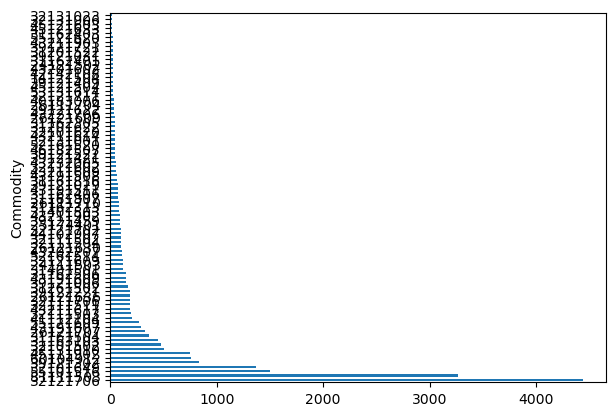

In [10]:
# get a dataframe of the commodities with the minimum number of commodities (20)
y_min_commodity = df6['Commodity'].value_counts().head(commodities_with_min_commodity)
df8 = df6[df6['Commodity'].isin(y_min_commodity.index.tolist())]
df8['Commodity'].value_counts().plot(kind='barh')

len(df8)

In [11]:
df8_value_counts = df8['Commodity'].value_counts()
len(df8_value_counts)
df8_value_counts

83

Commodity
32121706    4438
81111503    3267
55101516    1502
32101649    1372
39121302     831
60104912     762
45111902     750
32131010     505
32101502     476
31163103     447
31161504     361
26121707     324
43191607     293
55121609     269
41112104     207
32111503     194
43211617     189
32111511     188
32111706     186
26121636     183
39122221     181
31261502     168
39121006     152
43191609     151
31162506     147
31401501     122
24111503     122
32121609     121
52161514     114
43202207     107
26121630     103
32111504     102
32111502     100
44102907     100
32121702      99
25174401      94
39121459      92
43211902      87
31401503      80
31162313      80
26111710      78
31161807      75
31162406      75
43191511      74
39121029      71
31161816      61
43191508      59
43211609      56
32111602      54
43232005      51
39121421      49
39121522      47
46182507      45
52161520      45
32131001      44
43211614      44
32101620      44
31201622      43
3116

In [12]:
len(df6)

21475

In [56]:
print('set minimum number of commodity samples in df6:')
min_commodity # set minimum number of commodity samples in df6
print('number of rows in df6:')
df6['Commodity'].value_counts().sum() # number of rows in df6
print('number of rows in df8:')
df8['Commodity'].value_counts().sum() # number of rows in df8
print('number of unique commodities in df8:')
df8['Commodity'].nunique() # number of unique commodities in df8
print('number of unique commodities in df6 that are not in df8:')
df6['Commodity'].nunique() - df8['Commodity'].nunique() # number of unique commodities in df6 that are not in df8
print('number of rows in df6 that are not in df8:')
len(df6) - len(df8) # number of rows in df6 that are not in df8
print('percentage of rows in df6 that are not in df8:')
percent_not_in_df8 = round(((len(df6) - len(df8))/len(df6)) * 100, 2)  # percentage of rows in df6 that are not in df8
print(str(percent_not_in_df8) + '%\n')
print('percentage of rows in df6 that are in df8:')
percent_in_df8 = round((1 - (len(df6) - len(df8))/len(df6)) * 100, 2) # percentage of rows in df6 that are in df8
print(str(percent_in_df8) + '%\n')

set minimum number of commodity samples in df6:


20

number of rows in df6:


21475

number of rows in df8:


20768

number of unique commodities in df8:


83

number of unique commodities in df6 that are not in df8:


114

number of rows in df6 that are not in df8:


707

percentage of rows in df6 that are not in df8:
3.29%

percentage of rows in df6 that are in df8:
96.71%



In [14]:
tfidf_vectors_df8 = TfidfVectorizer()
vectorized_tokens_df8 = tfidf_vectors_df8.fit_transform(df8['Product_Description'])


In [15]:
tfidf_vectors_df8_inv = tfidf_vectors_df8.inverse_transform(vectorized_tokens_df8)
df8['TF-IDF'] = list(tfidf_vectors_df8_inv)
df8

,Product ID,DESCRIPTIONS,UNSPSC CODES,UNSPSC Code Description,ProductID_Type,TOKENS,Product_Description,Segment,Family,Class,Commodity,TF-IDF
0,0,set up sheet for ccx600 d,55101516,Operation or instruction manuals,numeric,"[set, sheet, ccx]","0,set up sheet for ccx600 d",55,5510,551015,55101516,"[ccx600, for, sheet, up, set]"
1,1000.004,"res, 270 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.004,res, 270 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706,"[cf, ohm, 270, res, 004, 1000]"
2,1000.005,"res, 200 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.005,res, 200 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706,"[200, 005, cf, ohm, res, 1000]"
3,1000.06,"res, 56k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.06,res, 56k, cf, 1/8 w, 5%",32,3212,321217,32121706,"[56k, 06, cf, res, 1000]"
4,1000.075,"res, 100k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.075,res, 100k, cf, 1/8 w, 5%",32,3212,321217,32121706,"[100k, 075, cf, res, 1000]"
...,...,...,...,...,...,...,...,...,...,...,...,...
25167,z462358-14f,"36k,5%,1/16w,0402,lf",32121706,Resistor or capacito,hyphenated,[lf],"z462358-14f,36k,5%,1/16w,0402,lf",32,3212,321217,32121706,"[14f, z462358, 36k, 0402, 16w, lf]"
25168,z462358-42f,"res,1/16w,510k ohms,5%,0402",32121706,Resistor or capacito,hyphenated,"[res, ohms]","z462358-42f,res,1/16w,510k ohms,5%,0402",32,3212,321217,32121706,"[42f, z462358, 510k, ohms, 0402, 16w, res]"
25169,z468610-04f,"c0g,15pf±025pf,50v,0201,lf",32121706,Resistor or capacito,hyphenated,"[pf±, pf, lf]","z468610-04f,c0g,15pf±025pf,50v,0201,lf",32,3212,321217,32121706,"[04f, z468610, 025pf, c0g, 15pf, 0201, lf, 50v]"
25170,z480086-01f,"side,actuated,16n,smd",39122221,Switch part or acces,hyphenated,"[side, actuated, smd]","z480086-01f,side,actuated,16n,smd",39,3912,391222,39122221,"[actuated, z480086, 01f, 16n, side, smd]"


In [16]:
# convert the true labels to encoded to class labels
label_encoder_df8 = LabelEncoder()
commodity_df8_encoded = label_encoder_df8.fit_transform(df8['Commodity'])


In [17]:
# create training, validation, and testing sets
# set test_size=0.21 to get 79/21 split and get representative sample of all 83 commodity codes in test set with min_commodity=20
X_train_df8, X_test_df8, y_train_df8, y_test_df8 = train_test_split(vectorized_tokens_df8, commodity_df8_encoded, test_size=0.21, random_state=42)
# set test_size=0.18 to get 82/18 split and get representative sample of all 83 commodity codes in validation set with min_commodity=20
X_train_df8, X_val_df8, y_train_df8, y_val_df8 = train_test_split(X_train_df8, y_train_df8, test_size=0.18, random_state=42) # do not need validation set for logistic regression


In [18]:
y_test_df8_decoded = label_encoder_df8.inverse_transform(y_test_df8)
y_train_df8_decoded = label_encoder_df8.inverse_transform(y_train_df8)
y_val_df8_decoded = label_encoder_df8.inverse_transform(y_val_df8)


In [57]:
# check y_val_df8_decoded and y_test_df8_decoded have all 83 commodity codes based on min_commodity=20
unique, counts = np.unique(y_val_df8_decoded, return_counts=True)
# unique, counts = np.unique(y_test_df8_decoded, return_counts=True)

y_dict = dict(zip(unique, counts))
len(y_dict)
y_dict


83

{'14121504': 4,
 '24111503': 23,
 '24121502': 3,
 '25174401': 18,
 '26111704': 11,
 '26111710': 9,
 '26121609': 5,
 '26121630': 12,
 '26121636': 33,
 '26121707': 56,
 '31161504': 43,
 '31161807': 15,
 '31161816': 10,
 '31162305': 3,
 '31162313': 14,
 '31162401': 6,
 '31162403': 2,
 '31162406': 12,
 '31162506': 30,
 '31163103': 55,
 '31201522': 6,
 '31201622': 6,
 '31261502': 20,
 '31401501': 21,
 '31401503': 12,
 '32101502': 65,
 '32101620': 3,
 '32101649': 195,
 '32111502': 17,
 '32111503': 32,
 '32111504': 13,
 '32111511': 29,
 '32111602': 5,
 '32111706': 27,
 '32121609': 21,
 '32121702': 16,
 '32121706': 610,
 '32121711': 2,
 '32131001': 8,
 '32131006': 2,
 '32131010': 77,
 '32131023': 1,
 '39121006': 21,
 '39121029': 11,
 '39121031': 5,
 '39121302': 106,
 '39121409': 10,
 '39121421': 7,
 '39121459': 7,
 '39121522': 5,
 '39121622': 5,
 '39121721': 4,
 '39122221': 22,
 '40183006': 6,
 '41112104': 28,
 '42142108': 5,
 '43191508': 8,
 '43191511': 10,
 '43191607': 52,
 '43191609': 21,
 

In [20]:
# create the SMOTE object
smote_df8 = SMOTE()

# fit and apply SMOTE to the training data
X_train_smote_df8, y_train_smote_df8 = smote_df8.fit_resample(X_train_df8, y_train_df8)

# print the shape of the new training data
print('Shape of X_train_count_smote:', X_train_smote_df8.shape)
print('Shape of y_train_smote:', y_train_smote_df8.shape)


Shape of X_train_count_smote: (237629, 25314)
Shape of y_train_smote: (237629,)


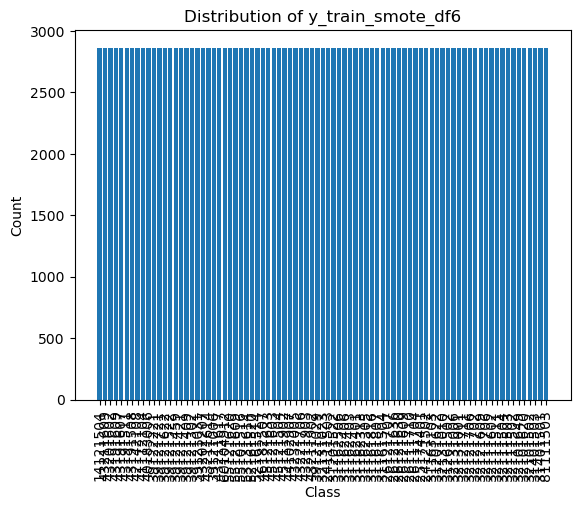

In [21]:
# create a dataframe of the class counts
class_counts = pd.DataFrame(label_encoder_df8.inverse_transform(y_train_smote_df8), columns=['class']).value_counts().reset_index(name='count')

# plot the class counts as a bar chart
plt.bar(class_counts['class'], class_counts['count'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of y_train_smote_df6')
plt.xticks(rotation=90)
plt.show();


In [22]:
# Load the saved model fitted/compiled from Google Colab (128 neurons)
model_02_tfidf_128 = load_model('final_nn_model_02_tfidf_128_encoded.h5', compile=False)
model_02_tfidf_128.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3240320   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 83)                10707     
                                                                 
Total params: 3,251,027
Trainable params: 3,251,027
Non-trainable params: 0
_________________________________________________________________


In [23]:
# # make predictions on the test data
pred_nn = model_02_tfidf_128.predict(X_test_df8.toarray())

# # convert the predictions from one-hot encoded format to class labels
pred_nn_labels = label_encoder_df8.inverse_transform(np.argmax(pred_nn, axis=1))

# generate a classification report
print_validation_report(y_test_df8_decoded, pred_nn_labels)

137/137 [==============================] - 2s 2ms/step
Classification Report
              precision    recall  f1-score   support

    14121504       1.00      0.80      0.89         5
    24111503       0.95      0.91      0.93        22
    24121502       0.00      0.00      0.00         1
    25174401       1.00      0.95      0.98        22
    26111704       1.00      0.80      0.89         5
    26111710       0.95      0.86      0.90        22
    26121609       0.80      1.00      0.89         4
    26121630       0.50      0.42      0.45        12
    26121636       1.00      0.94      0.97        35
    26121707       0.83      0.84      0.83        74
    31161504       0.97      1.00      0.99        75
    31161807       0.93      0.88      0.90        16
    31161816       1.00      0.87      0.93        15
    31162305       1.00      1.00      1.00        12
    31162313       0.80      0.75      0.77        16
    31162401       1.00      1.00      1.00         2
    

In [24]:
# default model callback settings

def create_checkpoint(model_name):
    return ModelCheckpoint(
        filepath=model_name,
        mode='min',
        save_best_only=True,
        save_weights_only=False,
        monitor='val_loss',
        verbose=1
    )

early_stopping = EarlyStopping(patience=10, restore_best_weights=True,monitor='val_loss')


In [25]:
commodities_with_min_commodity

83

In [26]:
y_train_smote_df8.shape[0]

237629

In [27]:
k.clear_session()
model_128 = Sequential()
model_128.add(Dense(128, input_shape=(X_train_smote_df8.shape[1],), activation='relu')) # 128 neurons in first layer
model_128.add(Dropout(0.5))
model_128.add(Dense(commodities_with_min_commodity, activation='softmax'))
model_128.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_128.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3240320   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 83)                10707     
                                                                 
Total params: 3,251,027
Trainable params: 3,251,027
Non-trainable params: 0
_________________________________________________________________


In [28]:
history_128 = model_128.fit(X_train_df8.toarray(), y_train_df8, validation_data=(X_val_df8.toarray(), y_val_df8), epochs=100, batch_size=64,
        callbacks=[create_checkpoint('final_nn_model_128_tfidf_enc_local.h5'),early_stopping], verbose=1)


Epoch 1/100
202/211 [===========================>..] - ETA: 0s - loss: 3.1390 - accuracy: 0.4115
Epoch 1: val_loss improved from inf to 2.08444, saving model to final_nn_model_128_tfidf_enc_local.h5
211/211 [==============================] - 2s 8ms/step - loss: 3.1008 - accuracy: 0.4168 - val_loss: 2.0844 - val_accuracy: 0.5562
Epoch 2/100
194/211 [==========================>...] - ETA: 0s - loss: 1.6008 - accuracy: 0.6680
Epoch 2: val_loss improved from 2.08444 to 1.30565, saving model to final_nn_model_128_tfidf_enc_local.h5
211/211 [==============================] - 1s 3ms/step - loss: 1.5755 - accuracy: 0.6722 - val_loss: 1.3056 - val_accuracy: 0.7387
Epoch 3/100
192/211 [==========================>...] - ETA: 0s - loss: 1.0013 - accuracy: 0.7954
Epoch 3: val_loss improved from 1.30565 to 0.91366, saving model to final_nn_model_128_tfidf_enc_local.h5
211/211 [==============================] - 1s 3ms/step - loss: 0.9911 - accuracy: 0.7968 - val_loss: 0.9137 - val_accuracy: 0.8192
Ep

In [29]:
# # make predictions on the test data
pred_nn_final_128 = model_128.predict(X_test_df8.toarray())

# # convert the predictions from one-hot encoded format to class labels
pred_nn_final_labels_128 = label_encoder_df8.inverse_transform(np.argmax(pred_nn_final_128, axis=1))

# generate a classification report
print_validation_report(y_test_df8_decoded, pred_nn_final_labels_128)


137/137 [==============================] - 0s 1ms/step
Classification Report
              precision    recall  f1-score   support

    14121504       1.00      0.80      0.89         5
    24111503       0.95      0.91      0.93        22
    24121502       0.00      0.00      0.00         1
    25174401       1.00      0.95      0.98        22
    26111704       1.00      0.80      0.89         5
    26111710       1.00      0.91      0.95        22
    26121609       0.80      1.00      0.89         4
    26121630       0.42      0.42      0.42        12
    26121636       1.00      0.94      0.97        35
    26121707       0.90      0.84      0.87        74
    31161504       0.99      1.00      0.99        75
    31161807       0.94      0.94      0.94        16
    31161816       1.00      0.87      0.93        15
    31162305       1.00      1.00      1.00        12
    31162313       0.80      0.75      0.77        16
    31162401       1.00      1.00      1.00         2
    

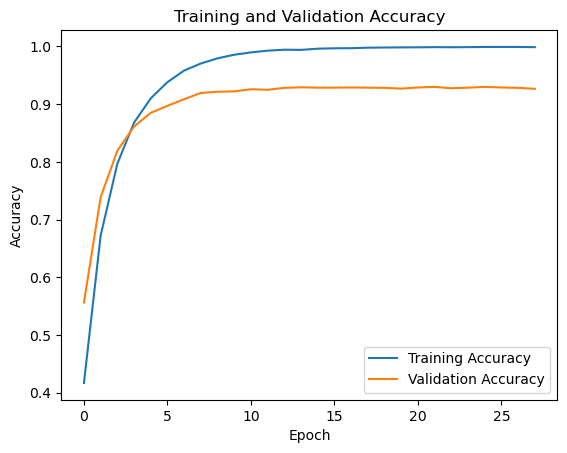

In [30]:
# plot the training and validation accuracy
plt.plot(history_128.history['accuracy'])
plt.plot(history_128.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show();

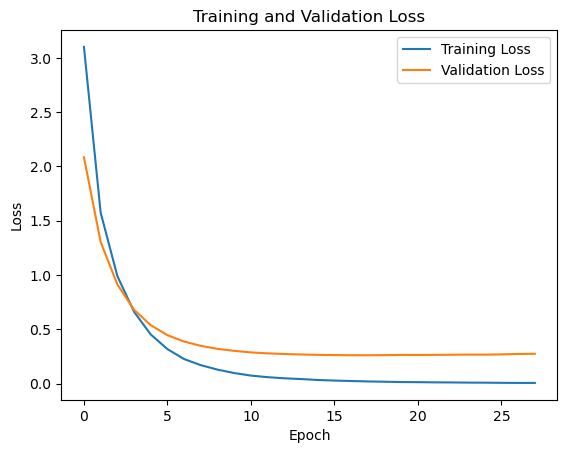

In [31]:
# plot the training and validation loss
plt.plot(history_128.history['loss'])
plt.plot(history_128.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show();


In [32]:
k.clear_session()
model_2048 = Sequential()
model_2048.add(Dense(2048, input_shape=(X_train_smote_df8.shape[1],), activation='relu')) # 2048 neurons in first layer
model_2048.add(Dropout(0.5))
model_2048.add(Dense(commodities_with_min_commodity, activation='softmax'))
model_2048.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_2048.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              51845120  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 83)                170067    
                                                                 
Total params: 52,015,187
Trainable params: 52,015,187
Non-trainable params: 0
_________________________________________________________________


In [33]:
history_2048 = model_2048.fit(X_train_df8.toarray(), y_train_df8, validation_data=(X_val_df8.toarray(), y_val_df8), epochs=100, batch_size=64,
        callbacks=[create_checkpoint('final_nn_model_2048_tfidf_enc_local.h5'),early_stopping], verbose=1)


Epoch 1/100
205/211 [============================>.] - ETA: 0s - loss: 1.8127 - accuracy: 0.6482
Epoch 1: val_loss improved from inf to 0.72805, saving model to final_nn_model_2048_tfidf_enc_local.h5
211/211 [==============================] - 3s 14ms/step - loss: 1.7884 - accuracy: 0.6530 - val_loss: 0.7281 - val_accuracy: 0.8578
Epoch 2/100
205/211 [============================>.] - ETA: 0s - loss: 0.3418 - accuracy: 0.9312
Epoch 2: val_loss improved from 0.72805 to 0.35982, saving model to final_nn_model_2048_tfidf_enc_local.h5
211/211 [==============================] - 2s 9ms/step - loss: 0.3393 - accuracy: 0.9315 - val_loss: 0.3598 - val_accuracy: 0.9110
Epoch 3/100
211/211 [==============================] - ETA: 0s - loss: 0.0926 - accuracy: 0.9833
Epoch 3: val_loss improved from 0.35982 to 0.28018, saving model to final_nn_model_2048_tfidf_enc_local.h5
211/211 [==============================] - 2s 9ms/step - loss: 0.0926 - accuracy: 0.9833 - val_loss: 0.2802 - val_accuracy: 0.928

In [34]:
# # make predictions on the test data
pred_nn_final_2048 = model_2048.predict(X_test_df8.toarray())

# # convert the predictions from one-hot encoded format to class labels
pred_nn_final_labels_2048 = label_encoder_df8.inverse_transform(np.argmax(pred_nn_final_2048, axis=1))

# generate a classification report
print_validation_report(y_test_df8_decoded, pred_nn_final_labels_2048)


137/137 [==============================] - 0s 2ms/step
Classification Report
              precision    recall  f1-score   support

    14121504       1.00      0.80      0.89         5
    24111503       1.00      0.91      0.95        22
    24121502       0.00      0.00      0.00         1
    25174401       1.00      0.95      0.98        22
    26111704       0.80      0.80      0.80         5
    26111710       0.95      0.91      0.93        22
    26121609       0.80      1.00      0.89         4
    26121630       0.43      0.50      0.46        12
    26121636       1.00      0.94      0.97        35
    26121707       0.89      0.85      0.87        74
    31161504       0.99      1.00      0.99        75
    31161807       0.93      0.88      0.90        16
    31161816       1.00      0.87      0.93        15
    31162305       1.00      1.00      1.00        12
    31162313       0.80      0.75      0.77        16
    31162401       1.00      1.00      1.00         2
    

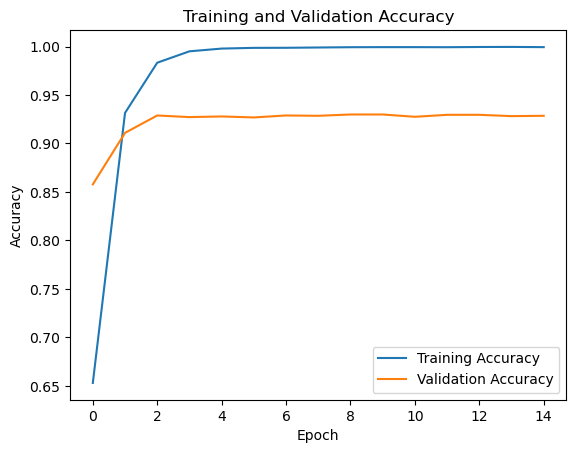

In [35]:
# plot the training and validation accuracy
plt.plot(history_2048.history['accuracy'])
plt.plot(history_2048.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show();

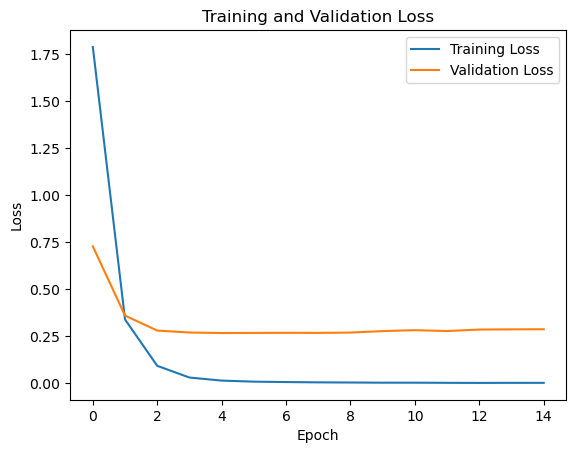

In [36]:
# plot the training and validation loss
plt.plot(history_2048.history['loss'])
plt.plot(history_2048.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show();


In [39]:
# Load the saved model fitted/compiled locally(128 neurons)
final_nn_model_128_tfidf_enc_local_load = load_model('final_nn_model_128_tfidf_enc_local.h5', compile=False)
final_nn_model_128_tfidf_enc_local_load.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3240320   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 83)                10707     
                                                                 
Total params: 3,251,027
Trainable params: 3,251,027
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Load the saved model fitted/compiled locally (2048 neurons)
final_nn_model_2048_tfidf_enc_local_load = load_model('final_nn_model_2048_tfidf_enc_local.h5', compile=False)
final_nn_model_2048_tfidf_enc_local_load.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              51845120  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 83)                170067    
                                                                 
Total params: 52,015,187
Trainable params: 52,015,187
Non-trainable params: 0
_________________________________________________________________


In [49]:
def predict_unspsc_code_nn(product_description):
    # Vectorize the product_description using the TF-IDF vectorizer
    vectorized_tokens = tfidf_vectors_df8.transform([product_description])
    
    # Make predictions using the trained model
    predictions = final_nn_model_128_tfidf_enc_local_load.predict(vectorized_tokens.toarray()) # local model (128 neurons)
    # predictions = final_nn_model_2048_tfidf_enc_local_load.predict(vectorized_tokens.toarray()) # local model (2048 neurons)
    # predictions = model_02_tfidf_128.predict(vectorized_tokens.toarray()) # Google Colab model (128 neurons)

    # Convert the predictions from one-hot encoded format to class labels
    predicted_labels = label_encoder_df8.inverse_transform(np.argmax(predictions, axis=1))
    
    return predicted_labels[0]

def predict_unspsc_code_nn_pd(product_id, description):
    product_description = ','.join([product_id, description])

    return predict_unspsc_code_nn(product_description)

In [50]:
product_id = 'ER-CR000W0402J5-C'
description = '0 Ohm;1/16 W;0402;+/-5%;=2;=2;AI=No;'
unspsc_code = '32121706'

# product_id = '2457-68644-001'
# description = 'CBL,ITP,LIFT SWT,SAM,XLR4,11'
# unspsc_code = '60104912'


In [51]:
result_nn = predict_unspsc_code_nn_pd(product_id, description)
print(result_nn)


1/1 [==============================] - 0s 18ms/step
32121706
